In [ ]:
## load csv file from cloud drive
from google.colab import drive
drive.mount('/content/drive/')
data_path = "/content/drive/MyDrive/Colab Notebooks/"  # this is your drive

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
data = pd.read_csv(data_path + 'data_standard.csv')
texts = data['text'].tolist()
labels = data['sentiment'].tolist()

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Convert tags to numerical values(0, 1, 2）

print(texts)

['What a great day!!! Looks like dream.', 'I feel sorry, I miss you here in the sea beach', "Don't angry me", 'We attend in the class just for listening teachers reading on slide. Just Nonsence  ', 'Those who want to go, let them go', 'Its night 2 am, feeling neutral', '2 am feedings for the baby are fun when he is all smiles and coos', 'Soooo high', ' Both of you', 'Today first time I arrive in the boat. Its amazing journey', 'Love is something like E=MC^2 rules', 'I really really like the song Cardigan by Taylor Swift', 'My Sharpie is running DANGERously low on ink', 'i want to go to music tonight but i lost my voice.', 'Always somewhere I miss you where I have been', "Don't distrube me", "I don't care, who are you and what can you do", 'i`ve been sick for the past few days ', "I'm come back home, my past job, its really good time for me", 'I will never fall in love until I found you', ' oh Maya, I`m so sorry!!  I hope you find her soon!! ', 'Playing with kids, its amazing', 'is clea

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# Building a vocabulary list
def build_vocab(texts):
    vocab = Counter()
    for text in texts:
        vocab.update(text.split())
    return vocab

vocab = build_vocab(train_texts)
vocab_size = len(vocab) + 1
word_to_idx = {word: idx + 1 for idx, word in enumerate(vocab)}

In [ ]:
# Text coding
def encode_texts(texts, word_to_idx, max_len):
    encoded_texts = []
    for text in texts:
        tokens = text.split()
        encoded = [word_to_idx.get(word, 0) for word in tokens]
        if len(encoded) < max_len:
            encoded += [0] * (max_len - len(encoded))
        else:
            encoded = encoded[:max_len]
        encoded_texts.append(encoded)
    return np.array(encoded_texts)

In [ ]:
max_len = 128  # Maximum Text Length
train_texts_encoded = encode_texts(train_texts, word_to_idx, max_len)
test_texts_encoded = encode_texts(test_texts, word_to_idx, max_len)

In [ ]:
# Custom dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = TextDataset(train_texts_encoded, train_labels)
test_dataset = TextDataset(test_texts_encoded, test_labels)

In [ ]:
# Data Loader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))  # [batch_size, seq_len, embedding_dim]
        output, (hidden, cell) = self.lstm(embedded)  # output: [batch_size, seq_len, hidden_dim * 2]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        else:
            hidden = self.dropout(hidden[-1, :, :])
        return self.fc(hidden)

# Set model parameter
vocab_size = len(word_to_idx) + 1
embedding_dim = 100
hidden_dim = 128
output_dim = 3
n_layers = 2
bidirectional = True
dropout = 0.5

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
class_counts = np.bincount(train_labels)  # Calculate the sample size for each category

class_weights = 1.0 / class_counts  # Calculate category weight

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)  # Learning rate scheduler

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Early Stop Method
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc, model):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

early_stopping = EarlyStopping(patience=5, verbose=True)

In [ ]:
# Training function
def train_model(model, optimizer, criterion, scheduler, early_stopping, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Test set evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in test_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

       # Learning rate scheduling
        scheduler.step(test_acc)

        # Application Early Stop Method
        early_stopping(test_acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
num_epochs = 40
train_losses, test_losses, train_accuracies, test_accuracies = train_model(model, optimizer, criterion, scheduler, early_stopping, num_epochs)

Epoch [1/40], Train Loss: 1.0992, Train Acc: 0.2932, Test Loss: 1.0991, Test Acc: 0.3200
Epoch [2/40], Train Loss: 1.0908, Train Acc: 0.4135, Test Loss: 1.0964, Test Acc: 0.3900
Epoch [3/40], Train Loss: 1.0810, Train Acc: 0.4486, Test Loss: 1.0875, Test Acc: 0.3900
Epoch [4/40], Train Loss: 1.0566, Train Acc: 0.5088, Test Loss: 1.0934, Test Acc: 0.4100
Epoch [5/40], Train Loss: 0.9956, Train Acc: 0.5263, Test Loss: 1.1257, Test Acc: 0.4000
EarlyStopping counter: 1 out of 5
Epoch [6/40], Train Loss: 0.8835, Train Acc: 0.5815, Test Loss: 1.0558, Test Acc: 0.4200
Epoch [7/40], Train Loss: 0.8069, Train Acc: 0.6366, Test Loss: 1.1400, Test Acc: 0.4200
Epoch [8/40], Train Loss: 0.7053, Train Acc: 0.7043, Test Loss: 1.0281, Test Acc: 0.5000
Epoch [9/40], Train Loss: 0.6368, Train Acc: 0.7193, Test Loss: 1.0209, Test Acc: 0.5500
Epoch [10/40], Train Loss: 0.5509, Train Acc: 0.7519, Test Loss: 1.0484, Test Acc: 0.5400
EarlyStopping counter: 1 out of 5
Epoch [11/40], Train Loss: 0.5270, Train 

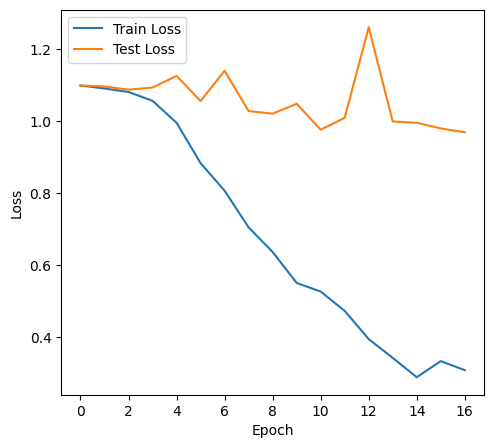

In [ ]:
# Draw loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

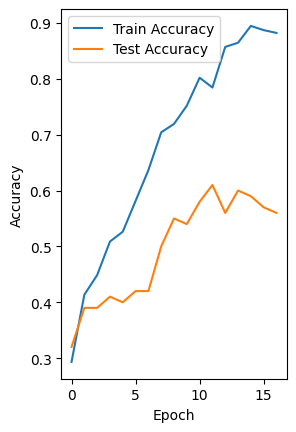

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluation model
def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

evaluate_model(model, test_loader)

Test Accuracy: 0.5600
Test Precision: 0.5917
Test Recall: 0.5654
Test F1 Score: 0.5638
